In [42]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from timeit import timeit
from IPython.display import display
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from joblib import dump, load
from imblearn.under_sampling import RandomUnderSampler

In [43]:
from compiledataset import load_dataset, compile_dataset

PATH = "/home/hampus/miun/master_thesis/Datasets"

datasets = {}

# dataset: pd.DataFrame = load_dataset(PATH + "/ORNL", "data_a.csv")
# dataset["remarks"] = "No DLC available"
# datasets["ROAD"] = dataset.to_dict("records")

dataset: pd.DataFrame = load_dataset(PATH + "/Survival", "data.csv")
dataset["remarks"] = "-"
datasets["Survival"] = dataset.to_dict("records")

# dataset: pd.DataFrame = load_dataset(PATH + "/Hisingen", "data.csv")
# dataset["remarks"] = "-"
# datasets["Hisingen"] = dataset.to_dict("records")


df = compile_dataset(datasets)
df.drop(columns=["d0", "d1", "d2", "d3", "d4", "d5", "d6", "d7", "data", "ID", "DLC", "t"], inplace=True, errors="ignore")

dataset = None # Release memory, as it isn't used for now
datasets = None

display(df)

,dt,dt_ID,dt_ID_data,dcs,name,class,dataset,type,Label
0,0.000444,0.009978,2.164212,0.107189,Fuzzy_dataset_SONATA,Sonata,Survival,none,0
1,0.000232,0.009977,0.046017,0.107189,Fuzzy_dataset_SONATA,Sonata,Survival,none,0
2,0.000248,0.009981,0.009991,0.107189,Fuzzy_dataset_SONATA,Sonata,Survival,none,0
3,0.000234,0.009978,0.046976,0.107189,Fuzzy_dataset_SONATA,Sonata,Survival,none,0
4,0.000241,0.009978,0.229608,0.107189,Fuzzy_dataset_SONATA,Sonata,Survival,none,0
...,...,...,...,...,...,...,...,...,...
1735835,0.000248,0.020620,0.020620,0.000000,FreeDrivingData_20171231_Spark,Spark,Survival,none,0
1735836,0.000235,0.013305,0.013305,0.000000,FreeDrivingData_20171231_Spark,Spark,Survival,none,0
1735837,0.000242,0.013092,0.013092,0.000000,FreeDrivingData_20171231_Spark,Spark,Survival,none,0
1735838,0.000435,0.012329,0.012329,0.000000,FreeDrivingData_20171231_Spark,Spark,Survival,none,0


In [44]:
df = df.loc[df["type"] != "masq"]
# df = df.loc[(df["type"] == "fuzz") | (df["type"] == "none")]

In [45]:
col = "dcs"
v_r         = df.loc[(df["Label"] == 0) & (df["dataset"] == "ROAD"), col]
v_sonata    = df.loc[(df["Label"] == 0) & (df["dataset"] == "Survival") & (df["class"] == "Sonata"), col]
v_soul      = df.loc[(df["Label"] == 0) & (df["dataset"] == "Survival") & (df["class"] == "Soul"), col]
v_spark     = df.loc[(df["Label"] == 0) & (df["dataset"] == "Survival") & (df["class"] == "Spark"), col]

print(v_r.mean(), v_r.std())
print(v_sonata.mean(), v_sonata.std())
print(v_soul.mean(), v_soul.std())
print(v_spark.mean(), v_spark.std())

nan nan
0.05594475491848506 0.08113177650718542
0.04803955737176265 0.05810224188552427
0.05336719738026015 0.08063728643324816


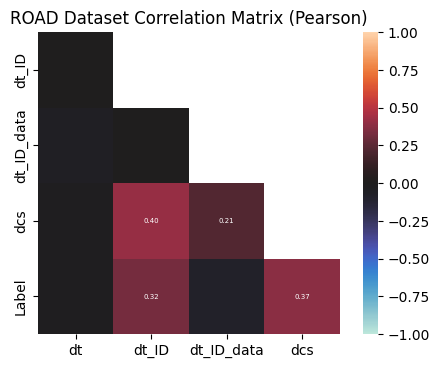

In [46]:
from plot_tools import plot_correlation_matrix

plot_correlation_matrix(df.drop(columns=["dataset", "type", "name", "class" "ID", "DLC", "t"], errors="ignore"))

In [47]:
from sklearn.preprocessing import StandardScaler

# for cl in ["unknown", "Sonata", "Soul", "Spark"]:
#     for col in ["dt", "dt_ID", "dt_ID_data", "dcs"]:
#         scaler = StandardScaler().fit(df.loc[(df["Label"] == 0) & (df["class"] == cl), df.columns == col])
#         df.loc[df["class"] == cl, col] = scaler.transform(df.loc[df["class"] == cl, df.columns == col])

for col in ["dt", "dt_ID", "dt_ID_data", "dcs"]:
    scaler = StandardScaler().fit(df.loc[df["Label"] == 0, df.columns == col])
    df.loc[:, df.columns ==col] = scaler.transform(df.loc[:, df.columns == col])

display(df)

,dt,dt_ID,dt_ID_data,dcs,name,class,dataset,type,Label
0,0.019201,-0.183233,0.041094,0.777710,Fuzzy_dataset_SONATA,Sonata,Survival,none,0
1,-0.324644,-0.183257,-0.350857,0.777710,Fuzzy_dataset_SONATA,Sonata,Survival,none,0
2,-0.298719,-0.183193,-0.357523,0.777710,Fuzzy_dataset_SONATA,Sonata,Survival,none,0
3,-0.321162,-0.183234,-0.350679,0.777710,Fuzzy_dataset_SONATA,Sonata,Survival,none,0
4,-0.310327,-0.183234,-0.316885,0.777710,Fuzzy_dataset_SONATA,Sonata,Survival,none,0
...,...,...,...,...,...,...,...,...,...
1735835,-0.298719,-0.029482,-0.355556,-0.724139,FreeDrivingData_20171231_Spark,Spark,Survival,none,0
1735836,-0.319614,-0.135170,-0.356910,-0.724139,FreeDrivingData_20171231_Spark,Spark,Survival,none,0
1735837,-0.308392,-0.138246,-0.356949,-0.724139,FreeDrivingData_20171231_Spark,Spark,Survival,none,0
1735838,0.005035,-0.149269,-0.357090,-0.724139,FreeDrivingData_20171231_Spark,Spark,Survival,none,0


In [48]:
# Stratify on the sub-dataset
X_train = df.drop(columns="name")
y_train = df["name"]

df = None # Release memory

# Split dataset into training and test data, stratify by the type of attack
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=0, shuffle=True, stratify=y_train)

# Use feature "Label" as classification label
d_temp: pd.DataFrame = pd.concat([X_train, y_train], axis="columns")
X_train, y_train = d_temp.drop(columns="Label"), d_temp["Label"]
d_temp: pd.DataFrame = pd.concat([X_test, y_test], axis="columns")
X_test, y_test = d_temp.drop(columns="Label"), d_temp["Label"]
d_temp = None # Release memory

In [49]:
rus = RandomUnderSampler(random_state=0)
X_train, y_train = rus.fit_resample(X_train, y_train)
bintr = np.bincount(y_train)
binte = np.bincount(y_test)
print(f"Labels\t\tTraining\tTesting\nNormal\t\t{bintr[0]}\t\t{binte[0]}\nAttack\t\t{bintr[1]}\t\t{binte[1]}")

Labels		Training	Testing
Normal		128216		465654
Attack		128216		55098


In [50]:
# train_index = X_train.loc[X_train["dataset"] == "Survival"].index
# test_index = X_test.loc[X_test["dataset"] == "ROAD"].index
# train_index = X_train.loc[(X_train["dataset"] == "Survival") & (X_train["name"] == "Fuzzy_dataset_SONATA")].index
# test_index = X_test.loc[(X_test["dataset"] == "ROAD") & (X_test["name"] == "fuzzing_attack_1")].index

# X_train = X_train.loc[train_index]
# y_train = y_train.loc[train_index]

# X_test = X_test.loc[test_index]
# y_test = y_test.loc[test_index]

In [51]:
X_train.drop(columns=["type", "dataset", "name", "class"], inplace=True)
X_test.drop(columns=["type", "dataset", "class"], inplace=True)

In [52]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=20, random_state=0, max_leaf_nodes=300, max_features="log2", warm_start=True)
clf.fit(X_train, y_train)

RandomForestClassifier(max_features='log2', max_leaf_nodes=300, n_estimators=20,
                       random_state=0, warm_start=True)

In [53]:
scores = cross_val_score(clf, X_train, y_train, scoring='f1', cv=10, n_jobs=-1)
print("Training F1: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std()))

pred = clf.predict(X_test.drop(columns="name"))

f1_scores = f1_score(y_test, pred, average='weighted')
print("Testing F1:  %0.4f(+/- %0.4f)" % (f1_scores.mean(), f1_scores.std()))

kappa_scores = cohen_kappa_score(y_test, pred)
print("Kappa score:  %0.4f(+/- %0.4f)" % (kappa_scores.mean(), kappa_scores.std()))

Training F1: 0.9990 (+/- 0.0002)
Testing F1:  0.9991(+/- 0.0000)
Kappa score:  0.9955(+/- 0.0000)


Plot test data predictions

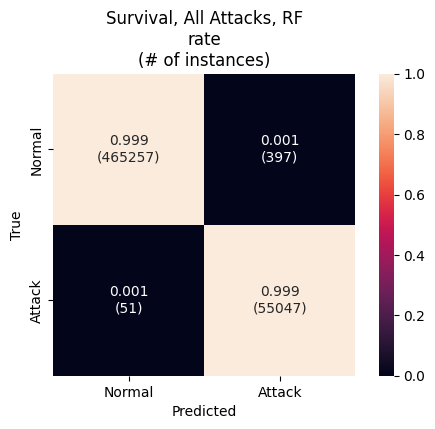

In [54]:
from plot_tools import plot_confusion_matrix

plot_confusion_matrix(y_test, pred, "Survival, All Attacks, RF\nrate\n(# of instances)")

Plot train data predictions

In [55]:
# pred_train = clf.predict(X_train)

# plot_confusion_matrix(y_train, pred_train, "Survival, All Attacks, RF\nrate\n(# of instances)")

Add trees trained on the FPs and FNs

In [56]:
# clf.set_params(n_estimators=30) # Add another 20 trees for the FN and FPs
# clf.fit(X_train.loc[y_train != pred_train], y_train.loc[y_train != pred_train])

Plot test data predictions again

In [57]:
# pred_test = clf.predict(X_test)

# plot_confusion_matrix(y_test, pred_test, "Survival, All Attacks, RF\nrate\n(# of instances)")

448
520304


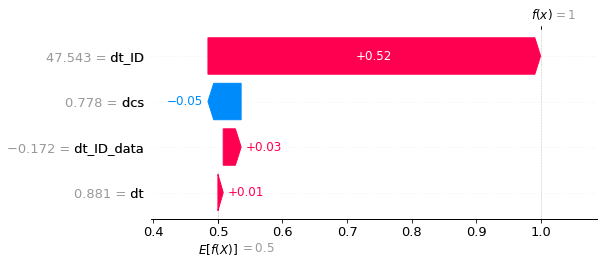

In [62]:
import shap
from shap_tools import *


exp = shap.TreeExplainer(clf)

# # Make sure that the ingested SHAP model (a TreeEnsemble object) makes the
# # same predictions as the original model
# assert np.abs(exp.model.predict(X_test_sample) - clf.predict_proba(X_test_sample)).max() < 1e-4

# # Make sure the SHAP values sum up to the model output (this is the local accuracy property)
# assert np.abs(exp.expected_value + exp.shap_values(X_test_sample).sum(1) - clf.predict_proba(X_test_sample)).max() < 1e-4

X_test_noname = X_test.drop(columns="name")
print(len(X_test_noname.loc[y_test != pred]))
print(len(X_test_noname.loc[y_test == pred]))
shap_false = get_explanation(exp, X_test_noname.loc[y_test != pred])
shap_FP = get_explanation(exp, X_test_noname.loc[(y_test != pred) & (pred == 1)])
shap_FN = get_explanation(exp, X_test_noname.loc[(y_test != pred) & (pred == 0)])
shap_true = get_explanation(exp, X_test_noname.loc[y_test == pred])
shap_TP = get_explanation(exp, X_test_noname.loc[(y_test == pred) & (pred == 1)])
shap_TN = get_explanation(exp, X_test_noname.loc[(y_test == pred) & (pred == 0)])

shap_TP_fuzz = get_explanation(exp, X_test.loc[(y_test == pred) & (pred == 1) & (X_test["name"] == "Fuzzy_dataset_SONATA")].drop(columns="name"))

shap_all = get_explanation(exp, X_test_noname)

# plot_beeswarm(shap_all)
shap.plots.waterfall(shap_TP_fuzz[0])

# shap_values = explainer(X_test.sample(1000, random_state=0))
# shap_values = shap.Explanation(shap_values[:, :, 1], feature_names=X_test.columns)

# shap.summary_plot(shap_values)


# shap.waterfall_plot(shap.Explanation(values=shap_values[int("which_class")][row], 
#                                          base_values=explainer.expected_value[int(which_class)], 
#                                          data=X_test.iloc[row],  # added this line
#                                          feature_names=X_test.columns.tolist()))
# shap.force_plot(explainer.expected_value[1], shap_values[1], features=X_test[:1], feature_names=X_test.columns)

# shap.plots.scatter(shap_values[:,"ones_w"])
# shap.summary_plot(shap_values[1], X_test.columns)

# plt.show()

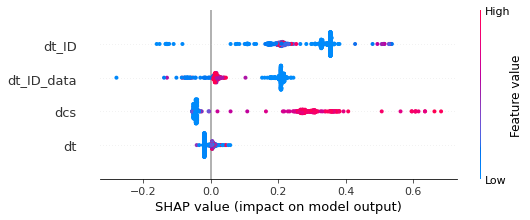

In [ ]:
plot_beeswarm(shap_TP)